In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
print(torch.cuda.is_available())

True


In [2]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(1, 10)
        self.linear2 = nn.Linear(10, 50)
        self.linear3 = nn.Linear(50, 200)
        
    def forward(self, x):
        
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        
        return x
    
net = Net()
print(net)
B = 2
with torch.no_grad():
    y_hat = net(torch.rand([B, 1]))
    
print(y_hat.shape)
        

Net(
  (linear1): Linear(in_features=1, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=200, bias=True)
)
torch.Size([2, 200])


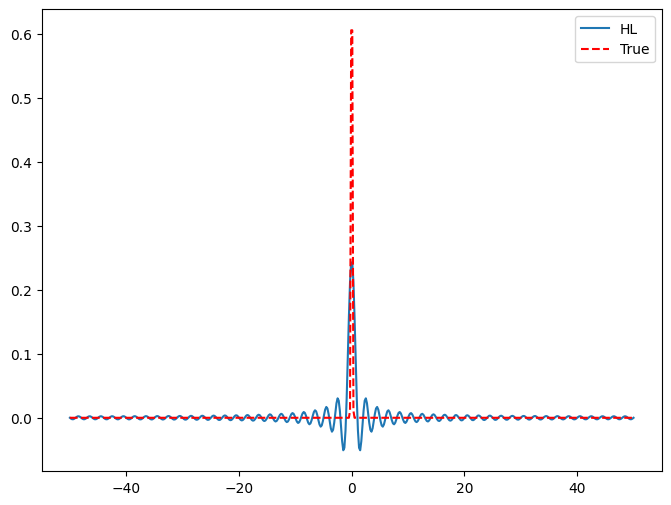

In [7]:
import numpy as np
import yaml
# import GPy
import matplotlib.pyplot as plt
# from KLexpansion import KLexpansion
from ReducedRankGP import ReducedRankGP
%matplotlib inline
def rbf_kernel(x1, x2, variance=1.0, lengthscale=1.0):
    
    # Compute the squared Euclidean distance
    dist_sq = np.sum((x1 - x2)**2, axis = 1)
    
    # Compute the kernel value
    kernel_value = variance * np.exp(-0.5 * dist_sq / lengthscale**2)
    
    return kernel_value

# Should be replaced with the path to your config file
config_file_path = './config.yaml'
with open(config_file_path, 'r') as file:
    config = yaml.safe_load(file)

# Kernel-based Gaussian process regression
res = 50
center = np.array([0.0])
# Generate a test grid for prediction
xPred = np.linspace(-res, res, 500)

# kernel = GPy.kern.RBF(input_dim=1,)
dummyXY = np.array([center])
K = rbf_kernel(xPred.reshape(-1, 1), dummyXY, variance=1.0, lengthscale=config['kernParams']['l'])

RGP = ReducedRankGP(config)
rgpPhi = RGP.buildEigenfunctions(xPred)
rgpOriginPhi = RGP.buildEigenfunctions(center)
HLapprox = np.dot(np.dot(rgpPhi.T, RGP.spectDensity), rgpOriginPhi)

fig = plt.figure(figsize=(8,6))
plt.plot(xPred, HLapprox, linestyle='-')
plt.plot(xPred, K, linestyle='--', color='red')  
plt.legend(['HL', 'True'])
plt.show()

In [8]:
K.shape

(500,)

In [9]:
'''
Loss = || phi(x1) phi(x2) - K(x1, x2) ||
'''
from tqdm import tqdm

net = Net()

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

pbar = tqdm(range(100000))
target_K = torch.tensor(K, dtype=torch.float32).cuda()

net.train().cuda()
# Batch size 500
x1 = torch.ones(1).reshape(-1, 1).cuda() * 0.0 
x2 = torch.linspace(-50, 50, 500).reshape(-1, 1).cuda()
print(x1.shape, x2.shape)
for iteration in pbar:

    y_hat_1 = net(x1)
    y_hat_2 = net(x2)
    
    loss = torch.norm(y_hat_1 @ y_hat_2.T - target_K)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    scheduler.step(loss)
    
    pbar.set_description(f'Iter: {iteration}, Loss: {loss.item()}')
    
            

/home/hj/anaconda3/envs/gp/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Iter: 97, Loss: 0.6291323304176331:   0%|          | 43/100000 [00:00<03:54, 426.79it/s]

torch.Size([1, 1]) torch.Size([500, 1])


Iter: 2144, Loss: 0.0008502596756443381:   2%|▏         | 2145/100000 [00:03<03:00, 541.01it/s]


KeyboardInterrupt: 

In [7]:
target_K.shape

torch.Size([500])

In [10]:
%matplotlib tk
with torch.no_grad():
    y_hat = net(x1) @ net(x2).T
    
plt.figure(figsize=(5,5))

plt.plot(target_K.cpu().numpy(), label='GT')
plt.plot(y_hat.squeeze().cpu().numpy(), label='DNN', linestyle='--')
plt.plot(HLapprox, label='HL')
plt.legend()
plt.grid()

In [ ]:
# Error
print(torch.norm(y_hat - target_K, p=2).item())
print(torch.norm(target_K - torch.tensor(HLapprox).cuda(), p=2).item())